## Questão 1:

O problema das barras pode ser modelado em termos de um programa linear da seguinte forma:

\begin{align*}
    \text{Maximizar }    & \sum_{i=1}^n l(i) x_i \\
    \text{ sujeito a } & \sum_{i=1}^n i.x_i = n \\
                        & x_i \in\mathbb{N} \quad \forall i \\
\end{align*}

onde as variáveis de decisão $x_i$ representam a quantidade de cortes de tamanho $i$ produzidos, $l(i)$ é a função de lucro de cada tamanho de segmento, e $n$ é o tamanho total da barra inicial. 

## Questão 2:

O problema de enumerar as possíveis configurações de corte equivale a enumerar todas as possíveis bitstrings de tamanho $n-1$, pois cada possível local de corte pode ou não ser efetivamente cortado em uma solução, e podemos então associar uma variável binária a essa escolha. É importante ressaltar que essa contagem considera como distintos cortes que seriam na prática equivalentes, pois não leva em consideração o ordenamento deles. Dentro dessa hiótese, o número total de cortes é $N=2^{n-1}$.

## Questão 3:

Podemos usar indução completa como base de um algoritmo recursivo. Primeiro, podemos representar uma solução para o problema de comprimento $k$, denotada $S_k$, por meio de um conjunto contendo os tamanhos de todos segmentos fabricados na solução. Disso, definimos o custo total dessa solução como 

$$l(S_k) = \sum_{i\in S_k} l(i)$$

 
Assim, podemos enumerar todas as possíveis soluções para $k$:

$$ S' = \{ \{1\} + S_{k-1},\; \{2\} + S_{k-2},\; \dots,\; \{k-1\} + S_1,\; \{k\} \}$$

e computar a solução $S_k$ como

$$ S_k = \max_{S'} \{ l(1) + l(S_{k-1}),\; \dots,\; l(k-1) + l(S_1),\; l(k) \} $$

Isso nos permite construir um algoritmo recursivo para o cálculo da solução ótima, partindo do caso base $k=1$. Para isso, nossa função recursiva deverá retornar a lista de comprimentos dos segmentos obtidos em sua execução, conjunto esse que será usado como base para o cálculo das possíveis soluções do próximo nível de recursão. 

## Questão 4:

Podemos observar que o algoritmo proposto acima realiza o cálculo repetido de soluções para um mesmo número $k$. Por exemplo, para o cálculo de $S_4$, temos

$$ S_4 = \max_{S'} \{ l(1) + l(S_{3}),\; l(2) + l(S_{2}),\; l(3) + l(S_{1}),\; l(4) \} $$

Vemos que a solução ótima para $k=2$ é calculada aqui, mas isso será feito novamente do zero na chamada de $S_3$.

## Questão 5:

Escrevendo o problema em termos de uma recursão, vemos que se trata de um problema com subestrutura ótima (tal qual o problema de _Minimal Spanning Tree_), onde se soubermos cortar de forma ótima uma parte da barra (por exemplo, os primeiros $k$ de comprimento de uma barra total de comprimento $n$), a solução total será a união desta solução $S_k$ com a solução para o restante da barra $S_{n-k}$. Sabemos no entanto que esse tipo de problema sempre nos permite desenvolver uma solução gulosa garantidamente ótima (de acordo com Cormen, Introduction to Algorithms). 

A característica de subestrutura ótima desse problema nos permite definir para todo comprimento $k$ um primeiro corte ótimo no ponto $i$ da barra, sendo a solução então dada por um segmento de comprimento $i$ junto à solução ótima de uma barra de tamanho $k-i$. Assim, vamos progressivamente diminuindo o comprimento da barra por meio desses primeiros cortes ideais.  

Uma solução para o problema das chamadas repetidas seria salvar as informações das soluções dos subproblemas calculados em alguma estrutura de dados, e referenciar esses valores quando formos recalcular uma solução. Juntando essas estratégias, podemos definir um algoritmo que retira segmentos progressivamente maiores da barra original, guardando em arrays os lucros ótimos de segmentos menores, assim como dos cortes feitos para se chegar nesses segmentos.

## Implementações

Abaixo foram implementados três algoritmos distintos para solucionar o problema do corte de barras, utilizando o método recursivo, iterativo, e por meio de programa linear (este último mais para comparar resultados do que qualquer coisa).

Notamos que em alguns casos existem soluções degeneradas (por exemplo, uma barra de comprimento 4 pode ser cortada em 2x2 ou 4x1 barras, sem diferença no lucro obtido), o que pode levar a diferenças nas soluções encontradas pelos algoritmos.

In [7]:
import cvxpy as cp
import numpy as np
import mosek
import matplotlib.pyplot as plt
import time

from typing import Tuple

In [41]:
def Profit(k:int) -> float:
    """ Returns the profit from selling a bar segment of size k

    Args:
        k (int): Size of the rod segment

    Returns:
        float: Profit from one unit of the input segment
    """

    profitTable = [0, 7, 14, 17, 19, 43, 64, 71, 80, 81, 84, 106, 107, 111, 119, 122, 134, 134]

    return profitTable[k] 


def ComputeTotalProfit(segmentSet:list[int]) -> float:
    """ Returns the total profit of a cut solution

    Args:
        segmentSet (list[int]): List of all segments in the cut, including repetitions

    Returns:
        float: Total profit from all the cuts in the input
    """

    totalProfit = 0
    for segment in segmentSet:
        totalProfit += Profit(segment)

    return totalProfit


def RecursiveOptimalCut(k) -> Tuple[list[int], float]:
    """ Recursive method for computing the optimal cut solution for a rod of length 'k'

    Args:
        k (int): total rod length 

    Returns:
        Tuple[list[int], float]: A list of segment lengths for the optimal cut solution, and its total profit
    """
    # base recursion case
    if k == 0:
        return [], 0
    
    else:
        bestSolutionProfit = -1
        for i in range(1, k+1):

            # computes all cuts smaller than current rod length
            _cut, _cutProfit = RecursiveOptimalCut(k-i)

            # computes profit from using each smaller cut + single cut for the remainder
            _profit = Profit(i) + _cutProfit

            # updates best solution
            if _profit > bestSolutionProfit:
                bestSolutionProfit = _profit
                bestSolution = _cut + [i]           

    return bestSolution, bestSolutionProfit


def IterativeOptimalCut(k:int):
    """ Iterative method for computing the optimal cut solution for a rod of length 'k'

    Args:
        k (int): total rod length 

    Returns:
        Tuple[list[int], float]: A list of segment lengths for the optimal cut solution, and its total profit
    """

    bestSolution = []

    # initializing arrays for storing the optimal first cuts and the optimal cut profit for each rod length 
    optimalPartialProfits = np.zeros(k+1)
    optimalFirstCuts = np.zeros(k+1)

    # find the best cuts and resulting profits for each segment size
    for j in range(0, k+1):

        partialProfit = -1
        # cut each segment of size 'j' in two, starting with size 1 cuts
        for i in range(0, j+1):

            if partialProfit < Profit(i+1) + optimalPartialProfits[j-i-1]:
                partialProfit = Profit(i+1) + optimalPartialProfits[j-i-1]
                optimalFirstCuts[j] = i+1

            optimalPartialProfits[j] = partialProfit
    
    # build final solution from previously computed optimal cuts
    while k > 0:
        cut = int(optimalFirstCuts[k-1])
        bestSolution += [cut]
        k = k - cut

    return bestSolution, ComputeTotalProfit(bestSolution)



def LinearProgramOptimalCut(k:int, profitTable:list[float]=None) -> Tuple[list[int], float]:
    """ Solves the rod cutting problem using a linear programming approach. 

    Args:
        k (int): Initial rod size
        profitTable(list): Unit profit for each rod size 

    Returns:
        Tuple[list, float]: A list of cut quantities for each possible cut size, and the total profit.
    """
    if k == 0:
        return 0, 0

    if profitTable == None:
        profitTable = np.array([0, 7, 14, 17, 19, 43, 64, 71, 80, 81, 84, 106, 107, 111, 119, 122, 134, 134])
        
    sizes = np.array([i+1 for i in range(k)])

    cuts = cp.Variable(k, integer=True, name='cuts')

    constraints = [cuts >= 0]
    constraints += [sizes.T @ cuts == k]

    objective = cp.Maximize( profitTable[:k].T @ cuts  )

    lp = cp.Problem(objective, constraints)
    lp.solve(solver="MOSEK", verbose=False)

    optimum = cuts.value.round(1)
    optimum = optimum.tolist()
    optimalValue = int(lp.value)

    return optimum, optimalValue



In [37]:
samples = 100
rodSize = 15

print("Método recursivo")
start = time.process_time()
print(RecursiveOptimalCut(rodSize))
end = time.process_time()
print(f"CPU time: {(end - start)/samples:.6f} s \n\n")

print("Método iterativo")
start = time.process_time()
print(IterativeOptimalCut(rodSize))
end = time.process_time()
print(f"CPU time: {(end - start)/samples:.6f} s \n\n")

print("Método por programação linear")
start = time.process_time()
print(LinearProgramOptimalCut(rodSize))
end = time.process_time()
print(f"CPU time: {(end - start)/samples:.6f} s \n\n")

Método recursivo
([8, 6, 1], 151)
CPU time: 0.000117 s 


Método iterativo
([1, 6, 8], 151)
CPU time: 0.000002 s 


Método por programação linear
([1.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 151)
CPU time: 0.000106 s 




Aqui, vemos que ambos os algoritmos obtém a mesma solução para o problema (a menos de degenerecências no valor ótimo de duas soluções diferentes). Note que a codificação da solução no método por programa linear é diferente, porém equvalente à utilizada nos outros algoritmos.  

## Comparando o tempo médio de execução dos três métodos propostos

In [44]:
averageTime = np.zeros((3,17))
rodSizes = np.array([i for i in range(17)])

samples = 100

for rodSize in rodSizes:
    # Método recursivo
    total = 0
    for _ in range(samples):
        start = time.process_time()
        RecursiveOptimalCut(rodSize)
        end = time.process_time()
        total += (end - start)
    averageTime[0, rodSize] = total/samples

    # Método iterativo
    total = 0
    for _ in range(samples):
        start = time.process_time()
        IterativeOptimalCut(rodSize)
        end = time.process_time()
        total += (end - start)
    averageTime[1, rodSize] = total/samples

    # Método por programação linear
    total = 0
    for _ in range(samples):
        start = time.process_time()
        LinearProgramOptimalCut(rodSize)
        end = time.process_time()
        total += (end - start)
    averageTime[2, rodSize] = total/samples



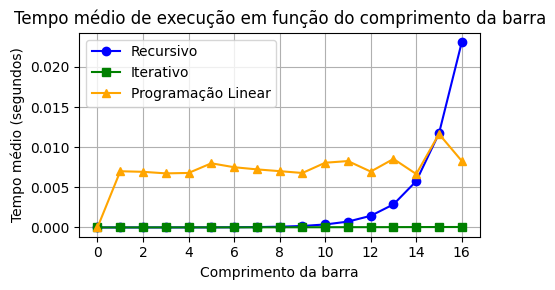

In [48]:
# Plotting
plt.figure(figsize=(5, 3))
plt.plot(rodSizes, averageTime[0], label="Recursivo", marker='o', color='blue')
plt.plot(rodSizes, averageTime[1], label="Iterativo", marker='s', color='green')
plt.plot(rodSizes, averageTime[2], label="Programação Linear", marker='^', color='orange')

plt.title("Tempo médio de execução em função do comprimento da barra")
plt.xlabel("Comprimento da barra")
plt.ylabel("Tempo médio (segundos)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

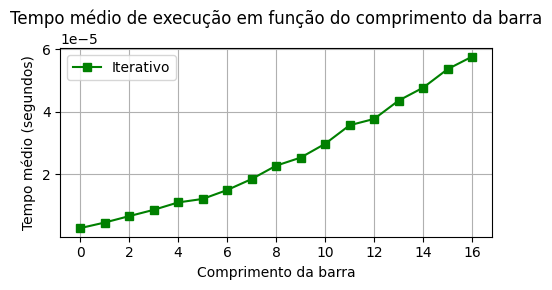

In [49]:
# Plotting
plt.figure(figsize=(5, 3))
plt.plot(rodSizes, averageTime[1], label="Iterativo", marker='s', color='green')


plt.title("Tempo médio de execução em função do comprimento da barra")
plt.xlabel("Comprimento da barra")
plt.ylabel("Tempo médio (segundos)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Observamos que o método iterativo obteve a melhor performance dentre os três. Assintoticamente, o método recursivo aparenta crescer exponencialmente em função do tamanho do problema, o que era esperado das análises teóricas feitas anteriormente. Era esperado ainda que o tempo de execução do método iterativo cresceria quadraticamente em função do tamanho do problema, o que é bem possível dada a relação obtida no segundo gráfico - a curva aparenta crescer um pouco mais rápido do que linearmente, mas tomar mais pontos seria interessante aqui. O método por PL se mostrou razoavelmente constante com apenas um leve aumento no tempo total de execução. Isso provavelmente se deve ao tempo de pré/pós processamento e parsing do problema pelo CVXPY.